In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import importlib
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from flearn.utils.model_utils import read_data
import os
import importlib
import random
import numpy as np

from flearn.models import client
from flearn.models import group
from flearn.trainers import grouprox
from flearn.trainers import fedprox
from flearn.trainers import fedavg

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Instructions for updating:
non-resource variables are not supported in the long term
Num GPUs Available:  1


In [2]:
params = {}
#DATASETS = ['sent140', 'nist', 'shakespeare', 'mnist', 'synthetic_iid', 'synthetic_0_0', 'synthetic_0.5_0.5', 'synthetic_1_1']

"""
Parameters that need to be manually set
"""

#params['dataset'] = 'sent140'
params['dataset'] = 'nist'
params['model'] = 'mlp'
#params['model'] = 'stacked_lstm'
params['optimizer'] = 'grouprox'
params['drop_percent'] = 0

if params['dataset'].startswith('mnist'):
  params['model_params'] = (10,)
  params['learning_rate'] = 0.03
  params['mu'] = 1
  params['num_group'] = 3
if params['dataset'] == 'nist':
  params['model_params'] = (26,)
  params['learning_rate'] = 0.003
  params['mu'] = 1
  params['num_group'] = 5
if params['dataset'] == 'sent140':
  params['model_params'] = (25, 2, 100) # seq_len, num_classes, num_hidden
  params['learning_rate'] = 0.3
  params['mu'] = 0.01
  params['num_group'] = 5
if params['dataset'].startswith('synthetic'):
  params['model_params'] = (10,)
  params['learning_rate'] = 0.01
  params['mu'] = 1
  params['num_group'] = 5

if params['optimizer']  == 'fedavg':
  pass
if params['optimizer']  == 'fedprox':
  pass
if params['optimizer']  == 'grouprox':
  params['FCD'] = False                       # If false, DCD will be used
  params['proximal'] = False
  params['RAC'] = False
  params['RCC'] = False
  params['allow_empty'] = True
  params['agg_lr'] = 0.05 ########## Group Aggregataion Rate
  
  # TEST Hyperparameters, Experimental Only
  params['evenly'] = False
  params['min_clients'] = 2
    
  # We implement IFCA and FeSEM base on grouprox
  params['ifca'] = False
  params['fesem'] = False
  
  """
  We immplement IFCA and FeSEM base on grouprox,
  Some configurations should be flush for above two CFL frameworks
  """
  if params['ifca'] == True or params['fesem'] == True:
    params['proximal'] = False
    params['RAC'] = False
    params['RCC'] = False
    params['allow_empty'] = True
    params['agg_lr'] = 0.0 # IFCA and FeSEM don't use this parameter
    
"""
Common parameters
"""
params['num_rounds'] = 300
params['num_epochs'] = 20
params['batch_size'] = 10
params['eval_every'] = 1
params['clients_per_round'] = 20 ################ Important ######################
params['seed'] = 233

""" Set the output CSV file name """
info = '{}-{}-{}'.format(params['optimizer'], params['dataset'], params['model'])
info2 = ''
suffix = '.csv'
if params['optimizer'] == 'fedavg':
  pass
if params['optimizer'] == 'fedprox':
  pass
if params['optimizer'] == 'grouprox':
  if params['ifca'] == False and params['fesem'] == False:
    if params['FCD'] == True:
      info2 = info2 + '-FCD'
    else:
      info2 = info2 + '-DCD'
  if params['ifca'] == True:
    info2 = info2 + '-IFCA'
  if params['fesem'] == True:
    info2 = info2 + '-FeSEM'
  
  info2 = info2 +  '-NumG{:1d}-Agglr{:.4}-Proximal{:.1}'.format(
    params['num_group'], params['agg_lr'], str(params['proximal']))
  
  if params['RCC'] == True:
    info2 = info2 + '-RCC.{:.1}'.format(str(params['RCC']))
  
  if params['RAC'] == True:
    info2 = info2 + '-RAC.{:.1}-Evenly{:.1}'.format(str(params['RAC']), str(params['evenly']))
  elif params['allow_empty'] == True:
    info2 = info2 + '-Empty{:.1}'.format(str(params['allow_empty']))
  elif params['allow_empty'] == False:
    info2 = info2 + '-Evenly{:.1}'.format(str(params['evenly']))

params['export_filename'] = info + info2 + suffix

print(params['export_filename'])

grouprox-nist-mlp-DCD-NumG5-Agglr0.05-ProximalF-EmptyT.csv


In [3]:
"""
Some preparations
"""

# read data
train_path = os.path.join('data', params['dataset'], 'data', 'train')
test_path = os.path.join('data', params['dataset'], 'data', 'test')
dataset = read_data(train_path, test_path)

# Load model
if params['dataset'].startswith('synthetic'):  # all synthetic datasets use the same model
  model_path = '%s.%s.%s.%s' % ('flearn', 'models', 'synthetic', params['model'])
elif params['dataset'].startswith('mnist'):
  model_path = '%s.%s.%s.%s' % ('flearn', 'models', 'mnist', params['model'])
else:
  model_path = '%s.%s.%s.%s' % ('flearn', 'models', params['dataset'], params['model'])
mod = importlib.import_module(model_path)
learner = getattr(mod, 'Model')

# Set seeds
params['sklearn_seed'] = params['seed']
random.seed(1 + params['seed'])
np.random.seed(12 + params['seed'])
tf.set_random_seed(123 + params['seed'])

# Set server
if params['optimizer'] == 'fedavg':
  server = fedavg.Server(params, learner, dataset)  
if params['optimizer'] == 'fedprox':
  server = fedprox.Server(params, learner, dataset)
if params['optimizer'] == 'grouprox':
  server = grouprox.Server(params, learner, dataset)

Using Group prox to Train


/home/lab/anaconda3/envs/FL/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/lab/anaconda3/envs/FL/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Epoch:   0%|                                                                                      | 0/1 [00:00<?, ?it/s]

200 Clients in Total
415258 Parameters in Total


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


Pre-training takes 2.964743137359619s seconds
SVD takes 0.7239553928375244s seconds
DCD Matrix calculation takes 0.15098834037780762s seconds
FCD Matrix calculation takes 0.1433272361755371s seconds
DCD [0.         0.01455415 0.29476362 0.14749908 0.24707718] 
FCD [0.         0.01236841 0.25191855 0.12350282 0.19845186] 
affinity [1.         0.9894647  0.01298085 0.3369573  0.04724744]
Clustering takes 0.033614397048950195s seconds
Clustering Results: Counter({0: 23, 2: 23, 1: 21, 4: 17, 3: 16})


In [4]:
"""
Test Ternary Similarity
"""
x, y = server.test_ternary_cosine_similariy()

Cossim_matrix shape: (200, 5)


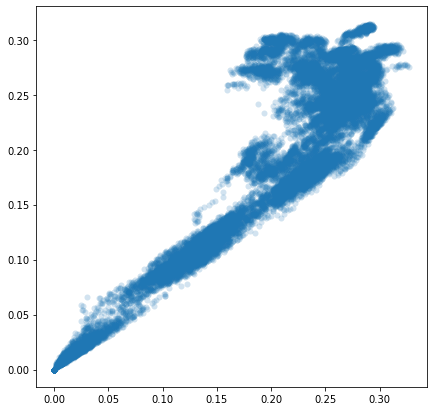

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.scatter(x[:50000], y[:50000], linewidths=0.01, alpha=0.2, norm=True)
plt.show()

In [ ]:
server.train()

Training with 20 workers ---


Cold start clients takes 6.218492746353149s seconds
Group 0, clients ['f_00018', 'f_00107', 'f_00098', 'f_00177', 'f_00007', 'f_00037']
Group 1, clients ['f_00182', 'f_00012', 'f_00152', 'f_00061']
Group 2, clients ['f_00154', 'f_00033', 'f_00074']
Group 3, clients ['f_00005', 'f_00146', 'f_00125']
Group 4, clients ['f_00170', 'f_00180', 'f_00080', 'f_00130']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 0 accuracy: 0.3421828908554572
At round 0 training accuracy: 0.37265135699373697
At round 0 training loss: 1.7838535055404083
Group 1
At round 0 accuracy: 0.3872832369942196
At round 0 training accuracy: 0.3918558077436582
At round 0 training loss: 1.8574563416842624
Group 2
At round 0 accuracy: 0.38481675392670156
At round 0 training accuracy: 0.3393188854489164
At round 0 training loss: 1.7741827324447985
Group 3
At round 0 accuracy: 0.40752351097178685
At round 0 training accuracy: 0.3938152011922504
At round 0 training loss: 1.6324668085166487
Group 4
At round 0 accuracy: 0.35342465753424657
At round 0 training accuracy: 0.36667728575979613
At round 0 training loss: 1.6940146848706539
At round 0 mean test accuracy: 0.37577962577962576 mean train accuracy: 0.3736678643200779 mean train loss: 1.7601770300296313                     number of test client: 200
The client-group discrepancy are: [0.18024164 0.15592919 0.19730017 0.19584637 0.16321189 0.20072056]
Begin gro

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 54.04it/s]

Begin group  2 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 27.31it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 6.214878797531128s seconds
Group 0, clients ['f_00058', 'f_00198', 'f_00168', 'f_00018', 'f_00118', 'f_00059']
Group 1, clients ['f_00102', 'f_00171', 'f_00011']
Group 2, clients ['f_00034', 'f_00184', 'f_00004']
Group 3, clients ['f_00095', 'f_00035', 'f_00136']
Group 4, clients ['f_00040', 'f_00029', 'f_00089', 'f_00110', 'f_00159']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 1 accuracy: 0.471976401179941
At round 1 training accuracy: 0.46868475991649267
At round 1 training loss: 1.7124872966698665
Group 1
At round 1 accuracy: 0.6107899807321773
At round 1 training accuracy: 0.6125945705384958
At round 1 training loss: 1.2316068748951383
Group 2
At round 1 accuracy: 0.44502617801047123
At round 1 training accuracy: 0.4678018575851393
At round 1 training loss: 2.0574824804676575
Group 3
At round 1 accuracy: 0.6739811912225705
At round 1 training accuracy: 0.6795827123695977
At round 1 training loss: 1.6988316849873424
Group 4
At round 1 accuracy: 0.5452054794520548
At round 1 training accuracy: 0.5546352341510035
At round 1 training loss: 1.6524781717278845
At round 1 mean test accuracy: 0.5514553014553014 mean train accuracy: 0.5587966628098167 mean train loss: 1.6350399745373814                     number of test client: 200
The client-group discrepancy are: [0.63838281 0.54539793 0.68357141 0.57671938 0.74361385 0.69671094]
Begin group  0

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 31.15it/s]

Begin group  1 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 79.27it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.919415235519409s seconds
Group 0 is empty.
Group 1, clients ['f_00112', 'f_00182', 'f_00012', 'f_00092', 'f_00002']
Group 2, clients ['f_00193', 'f_00054', 'f_00013', 'f_00174', 'f_00044', 'f_00003', 'f_00113', 'f_00014']
Group 3, clients ['f_00085', 'f_00115', 'f_00035', 'f_00126']
Group 4, clients ['f_00029', 'f_00199', 'f_00010']


Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 141.36it/s]

Group 0
At round 2 accuracy: 0.39233038348082594
At round 2 training accuracy: 0.41092553931802367
At round 2 training loss: 1.972347861457883
Group 1
At round 2 accuracy: 0.605009633911368
At round 2 training accuracy: 0.6092567868268803
At round 2 training loss: 1.2561897528160928
Group 2
At round 2 accuracy: 0.693717277486911
At round 2 training accuracy: 0.6826625386996904
At round 2 training loss: 1.9232917456250442
Group 3
At round 2 accuracy: 0.5736677115987461
At round 2 training accuracy: 0.5830849478390462
At round 2 training loss: 1.2518955071174973
Group 4
At round 2 accuracy: 0.5917808219178082
At round 2 training accuracy: 0.5766167569289583
At round 2 training loss: 1.3568414544254095
At round 2 mean test accuracy: 0.5774428274428275 mean train accuracy: 0.5784665976493515 mean train loss: 1.531288576085445                     number of test client: 200
The client-group discrepancy are: [0.78180054 0.         0.92788399 0.76292476 0.80231759 0.56130744]
Begin group  1 tr

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 89.37it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 105.29it/s]

Begin group  4 training


Training groups takes 4.328243732452393s seconds
Group 0, clients ['f_00197', 'f_00058']
Group 1, clients ['f_00051', 'f_00082', 'f_00041']
Group 2, clients ['f_00183', 'f_00083', 'f_00173', 'f_00003']
Group 3, clients ['f_00046', 'f_00025', 'f_00095']
Group 4, clients ['f_00040', 'f_00139', 'f_00170', 'f_00070', 'f_00100', 'f_00179', 'f_00190', 'f_00159']


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 85.75it/s]

Group 0
At round 3 accuracy: 0.39233038348082594
At round 3 training accuracy: 0.41092553931802367
At round 3 training loss: 1.960194380128226
Group 1
At round 3 accuracy: 0.8053949903660886
At round 3 training accuracy: 0.8157543391188251
At round 3 training loss: 0.9490554331738418
Group 2
At round 3 accuracy: 0.612565445026178
At round 3 training accuracy: 0.5934984520123839
At round 3 training loss: 1.4352033415630505
Group 3
At round 3 accuracy: 0.7366771159874608
At round 3 training accuracy: 0.746274217585693
At round 3 training loss: 1.165488125203974
Group 4
At round 3 accuracy: 0.6219178082191781
At round 3 training accuracy: 0.6237655304237019
At round 3 training loss: 1.2114771301672693
At round 3 mean test accuracy: 0.6481288981288982 mean train accuracy: 0.6531270933560684 mean train loss: 1.3071894158737558                     number of test client: 200
The client-group discrepancy are: [0.86191658 0.61560044 1.16842842 0.71670996 0.88062737 0.87414045]
Begin group  0 tr

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.254792928695679s seconds
Group 0, clients ['f_00128', 'f_00177', 'f_00088', 'f_00187', 'f_00188', 'f_00138']
Group 1, clients ['f_00011', 'f_00001', 'f_00111', 'f_00061', 'f_00191', 'f_00171']
Group 2, clients ['f_00123', 'f_00184', 'f_00033', 'f_00084']
Group 3, clients ['f_00175']
Group 4, clients ['f_00099', 'f_00090', 'f_00199']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 4 accuracy: 0.49852507374631266
At round 4 training accuracy: 0.5
At round 4 training loss: 1.3019903897409566
Group 1
At round 4 accuracy: 0.6223506743737958
At round 4 training accuracy: 0.6226079216733422
At round 4 training loss: 1.0017892147733947
Group 2
At round 4 accuracy: 0.5445026178010471
At round 4 training accuracy: 0.5154798761609907
At round 4 training loss: 1.4236785443021047
Group 3
At round 4 accuracy: 0.6081504702194357
At round 4 training accuracy: 0.606929955290611
At round 4 training loss: 1.261972361034679
Group 4
At round 4 accuracy: 0.7589041095890411
At round 4 training accuracy: 0.758521822236381
At round 4 training loss: 0.9627818111383676
At round 4 mean test accuracy: 0.6086278586278586 mean train accuracy: 0.6034955240241154 mean train loss: 1.1723858919422299                     number of test client: 200
The client-group discrepancy are: [0.96282211 0.95757597 1.01796479 0.79682738 1.2180693  0.99927296]
Begin group  0 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.08it/s]

Begin group  1 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 28.15it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training
Begin group  4 training


Training groups takes 4.593153715133667s seconds
Group 0, clients ['f_00077', 'f_00148', 'f_00028', 'f_00188', 'f_00117']
Group 1, clients ['f_00151', 'f_00122', 'f_00071', 'f_00021']
Group 2, clients ['f_00154', 'f_00034', 'f_00104', 'f_00003', 'f_00134']
Group 3, clients ['f_00006', 'f_00055']
Group 4, clients ['f_00119', 'f_00149', 'f_00040', 'f_00039']


Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 147.26it/s]

Group 0
At round 5 accuracy: 0.5811209439528023
At round 5 training accuracy: 0.5619345859429367
At round 5 training loss: 1.1983882518551294
Group 1
At round 5 accuracy: 0.6589595375722543
At round 5 training accuracy: 0.6706720071206053
At round 5 training loss: 1.5791391110123132
Group 2
At round 5 accuracy: 0.468586387434555
At round 5 training accuracy: 0.44303405572755417
At round 5 training loss: 1.6160101824869681
Group 3
At round 5 accuracy: 0.5297805642633229
At round 5 training accuracy: 0.533532041728763
At round 5 training loss: 1.4288879735325914
Group 4
At round 5 accuracy: 0.6191780821917808
At round 5 training accuracy: 0.6282255495380694
At round 5 training loss: 1.086869103014564
At round 5 mean test accuracy: 0.5784823284823285 mean train accuracy: 0.5763351805614761 mean train loss: 1.4010930714011374                     number of test client: 200
The client-group discrepancy are: [1.13247095 0.99403094 1.33703471 0.9810198  1.29714749 1.20793284]
Begin group  0 tr

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 26.52it/s]

Begin group  1 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 53.69it/s]

Begin group  2 training


Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 75.64it/s]

Begin group  4 training


Training groups takes 4.203185558319092s seconds
Group 0, clients ['f_00118', 'f_00088', 'f_00108', 'f_00158']
Group 1, clients ['f_00011', 'f_00152', 'f_00151', 'f_00081']
Group 2, clients ['f_00134', 'f_00093', 'f_00004', 'f_00094', 'f_00013']
Group 3, clients ['f_00145', 'f_00006', 'f_00156', 'f_00115']
Group 4, clients ['f_00149', 'f_00019', 'f_00030']


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 33.55it/s]

Group 0
At round 6 accuracy: 0.5929203539823009
At round 6 training accuracy: 0.6012526096033403
At round 6 training loss: 1.0122738232733728
Group 1
At round 6 accuracy: 0.6377649325626205
At round 6 training accuracy: 0.6377392078326658
At round 6 training loss: 1.0243116727950152
Group 2
At round 6 accuracy: 0.7356020942408377
At round 6 training accuracy: 0.730030959752322
At round 6 training loss: 1.1576969191016797
Group 3
At round 6 accuracy: 0.6394984326018809
At round 6 training accuracy: 0.63301043219076
At round 6 training loss: 1.0394319725374173
Group 4
At round 6 accuracy: 0.736986301369863
At round 6 training accuracy: 0.7330359987257088
At round 6 training loss: 1.191195394847377
At round 6 mean test accuracy: 0.6683991683991684 mean train accuracy: 0.6669508556117167 mean train loss: 1.0828141059036138                     number of test client: 200
The client-group discrepancy are: [0.86180866 0.82528786 0.77625734 0.89748746 0.79918865 1.04860017]
Begin group  0 train

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 91.80it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 95.38it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 5.436070919036865s seconds
Group 0, clients ['f_00108', 'f_00138', 'f_00188']
Group 1, clients ['f_00022', 'f_00011', 'f_00002', 'f_00121']
Group 2, clients ['f_00094', 'f_00063', 'f_00024', 'f_00153']
Group 3, clients ['f_00086', 'f_00195', 'f_00066', 'f_00096', 'f_00065', 'f_00155', 'f_00046']
Group 4, clients ['f_00120', 'f_00099']


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 70.01it/s]

Group 0
At round 7 accuracy: 0.5929203539823009
At round 7 training accuracy: 0.5601948503827419
At round 7 training loss: 1.6780288617438381
Group 1
At round 7 accuracy: 0.7013487475915221
At round 7 training accuracy: 0.6931464174454829
At round 7 training loss: 0.7504243260497351
Group 2
At round 7 accuracy: 0.6832460732984293
At round 7 training accuracy: 0.6758513931888545
At round 7 training loss: 0.7950208390091226
Group 3
At round 7 accuracy: 0.64576802507837
At round 7 training accuracy: 0.639344262295082
At round 7 training loss: 0.8974632166004038
Group 4
At round 7 accuracy: 0.736986301369863
At round 7 training accuracy: 0.7234788149092067
At round 7 training loss: 1.078782188717671
At round 7 mean test accuracy: 0.6761954261954262 mean train accuracy: 0.6634796906400341 mean train loss: 1.0083471008866098                     number of test client: 200
The client-group discrepancy are: [1.04372706 0.27071813 1.02995917 1.24207779 1.2904791  0.97044264]
Begin group  0 train

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 62.99it/s]

Begin group  2 training


Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 88.80it/s]

Begin group  4 training


Training groups takes 4.888156175613403s seconds
Group 0, clients ['f_00067', 'f_00088', 'f_00128', 'f_00117', 'f_00169', 'f_00027']
Group 1, clients ['f_00161', 'f_00181', 'f_00142', 'f_00151', 'f_00001']
Group 2, clients ['f_00193', 'f_00103']
Group 3, clients ['f_00065', 'f_00146']
Group 4, clients ['f_00069', 'f_00119', 'f_00190', 'f_00150', 'f_00000']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 8 accuracy: 0.6902654867256637
At round 8 training accuracy: 0.6579679888656924
At round 8 training loss: 1.636933809883825
Group 1
At round 8 accuracy: 0.6396917148362236
At round 8 training accuracy: 0.6461949265687583
At round 8 training loss: 1.026049727365925
Group 2
At round 8 accuracy: 0.7198952879581152
At round 8 training accuracy: 0.701547987616099
At round 8 training loss: 0.7291291781900099
Group 3
At round 8 accuracy: 0.7241379310344828
At round 8 training accuracy: 0.7399403874813711
At round 8 training loss: 0.8488289902622405
Group 4
At round 8 accuracy: 0.7232876712328767
At round 8 training accuracy: 0.7088244663905703
At round 8 training loss: 0.751493398533311
At round 8 mean test accuracy: 0.6943866943866944 mean train accuracy: 0.686438097558005 mean train loss: 0.9931123121492131                     number of test client: 200
The client-group discrepancy are: [1.13284137 1.00202783 1.28635672 1.37234064 0.83540547 1.1594769 ]
Begin group  0 train

Begin group  1 training


Epoch:  80%|████████████████████████████████████████████████████████████               | 16/20 [00:00<00:00, 153.06it/s]

Begin group  2 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 88.50it/s]

Begin group  3 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 67.79it/s]

Begin group  4 training


Training groups takes 3.9013116359710693s seconds
Group 0, clients ['f_00158', 'f_00027', 'f_00037']
Group 1, clients ['f_00101']
Group 2, clients ['f_00084', 'f_00054', 'f_00123', 'f_00053', 'f_00103', 'f_00003', 'f_00163', 'f_00174']
Group 3, clients ['f_00156', 'f_00116']
Group 4, clients ['f_00060', 'f_00109', 'f_00140', 'f_00039', 'f_00100', 'f_00069']


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 77.27it/s]

Group 0
At round 9 accuracy: 0.6843657817109144
At round 9 training accuracy: 0.6941544885177453
At round 9 training loss: 1.1157011828056707
Group 1
At round 9 accuracy: 0.6589595375722543
At round 9 training accuracy: 0.668669336893636
At round 9 training loss: 0.8444881319111063
Group 2
At round 9 accuracy: 0.7774869109947644
At round 9 training accuracy: 0.7798761609907121
At round 9 training loss: 0.9090866526260095
Group 3
At round 9 accuracy: 0.7554858934169278
At round 9 training accuracy: 0.7522354694485842
At round 9 training loss: 0.8696133137948466
Group 4
At round 9 accuracy: 0.684931506849315
At round 9 training accuracy: 0.6699585855367951
At round 9 training loss: 0.7531435023488874
At round 9 mean test accuracy: 0.7079002079002079 mean train accuracy: 0.7089093234273187 mean train loss: 0.8913077364516501                     number of test client: 200
The client-group discrepancy are: [0.98907716 0.75842078 1.85281184 0.93180388 0.95631173 1.04773576]
Begin group  0 tr

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training
Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 92.46it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 5.549186706542969s seconds
Group 0, clients ['f_00059', 'f_00198', 'f_00098', 'f_00078']
Group 1, clients ['f_00052', 'f_00162', 'f_00002', 'f_00142', 'f_00111']
Group 2, clients ['f_00124', 'f_00063']
Group 3, clients ['f_00005', 'f_00055', 'f_00075', 'f_00185']
Group 4, clients ['f_00020', 'f_00019', 'f_00069', 'f_00010', 'f_00109']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 10 accuracy: 0.6253687315634219
At round 10 training accuracy: 0.6221294363256785
At round 10 training loss: 0.984437361141834
Group 1
At round 10 accuracy: 0.6763005780346821
At round 10 training accuracy: 0.6824655095683133
At round 10 training loss: 1.2992236984070535
Group 2
At round 10 accuracy: 0.7958115183246073
At round 10 training accuracy: 0.7925696594427245
At round 10 training loss: 1.0296000925795212
Group 3
At round 10 accuracy: 0.7210031347962382
At round 10 training accuracy: 0.7131147540983607
At round 10 training loss: 1.1956775517448583
Group 4
At round 10 accuracy: 0.663013698630137
At round 10 training accuracy: 0.6616756928958267
At round 10 training loss: 0.8011408124087
At round 10 mean test accuracy: 0.6959459459459459 mean train accuracy: 0.6945983801230132 mean train loss: 1.0789581715260272                     number of test client: 200
The client-group discrepancy are: [1.08936807 1.47056882 1.0092045  1.14231768 1.28409962 0.68760596]
Begi

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 33.32it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 44.15it/s]

Begin group  2 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 26.26it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.35it/s]

Begin group  4 training


Training groups takes 6.3806798458099365s seconds
Group 0 is empty.
Group 1, clients ['f_00022', 'f_00041', 'f_00111']
Group 2, clients ['f_00174', 'f_00033', 'f_00173', 'f_00053', 'f_00134', 'f_00143', 'f_00094', 'f_00073', 'f_00014', 'f_00063']
Group 3, clients ['f_00186', 'f_00056', 'f_00055', 'f_00016']
Group 4, clients ['f_00130', 'f_00060', 'f_00000']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 11 accuracy: 0.6696165191740413
At round 11 training accuracy: 0.674669450243563
At round 11 training loss: 1.4546318829121818
Group 1
At round 11 accuracy: 0.7861271676300579
At round 11 training accuracy: 0.7970627503337784
At round 11 training loss: 0.6631773457653957
Group 2
At round 11 accuracy: 0.7513089005235603
At round 11 training accuracy: 0.7507739938080495
At round 11 training loss: 0.6367270778576287
Group 3
At round 11 accuracy: 0.8275862068965517
At round 11 training accuracy: 0.8192995529061102
At round 11 training loss: 1.056556021347753
Group 4
At round 11 accuracy: 0.6684931506849315
At round 11 training accuracy: 0.6702771583306786
At round 11 training loss: 0.7351511835425323
At round 11 mean test accuracy: 0.7432432432432432 mean train accuracy: 0.7459350831252665 mean train loss: 0.8745506005283976                     number of test client: 200
The client-group discrepancy are: [0.98296057 0.         0.52090965 0.98227657 1.49447532 0.76527184]
B

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.505172491073608s seconds
Group 0, clients ['f_00007', 'f_00098', 'f_00138']
Group 1, clients ['f_00182', 'f_00172', 'f_00021', 'f_00011', 'f_00061', 'f_00032', 'f_00132', 'f_00031', 'f_00181']
Group 2, clients ['f_00023', 'f_00063', 'f_00164', 'f_00173']
Group 3, clients ['f_00095', 'f_00016', 'f_00085']
Group 4, clients ['f_00120']


Group 0
At round 12 accuracy: 0.6696165191740413
At round 12 training accuracy: 0.674669450243563
At round 12 training loss: 1.446511748999295
Group 1
At round 12 accuracy: 0.7148362235067437
At round 12 training accuracy: 0.7160658655985759
At round 12 training loss: 0.6876141486078514
Group 2
At round 12 accuracy: 0.7801047120418848
At round 12 training accuracy: 0.7746130030959752
At round 12 training loss: 0.6970476719755506
Group 3
At round 12 accuracy: 0.7554858934169278
At round 12 training accuracy: 0.7690014903129657
At round 12 training loss: 0.6618509889315208
Group 4
At round 12 accuracy: 0.8082191780821918
At round 12 training accuracy: 0.8088563236699586
At round 12 training loss: 0.7676863045297865
At round 12 mean test accuracy: 0.7442827442827443 mean train accuracy: 0.7467267523293344 mean train loss: 0.8333872538310632                     number of test client: 200
The client-group discrepancy are: [1.04959253 0.84243979 1.28111531 1.16951857 0.64272988 0.32822944]
B

Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 45.77it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 47.69it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 77.04it/s]

Begin group  4 training


Training groups takes 5.014981746673584s seconds
Group 0, clients ['f_00198', 'f_00128', 'f_00097']
Group 1, clients ['f_00042', 'f_00102', 'f_00132']
Group 2, clients ['f_00023', 'f_00033', 'f_00104']
Group 3, clients ['f_00155', 'f_00096', 'f_00095', 'f_00106', 'f_00065']
Group 4, clients ['f_00179', 'f_00159', 'f_00110', 'f_00089', 'f_00079', 'f_00070']


Epoch:  65%|████████████████████████████████████████████████▊                          | 13/20 [00:00<00:00, 122.93it/s]

Group 0
At round 13 accuracy: 0.6873156342182891
At round 13 training accuracy: 0.6816283924843424
At round 13 training loss: 1.3929304860703382
Group 1
At round 13 accuracy: 0.7263969171483622
At round 13 training accuracy: 0.7300845571873609
At round 13 training loss: 0.5987989434439392
Group 2
At round 13 accuracy: 0.7513089005235603
At round 13 training accuracy: 0.7476780185758514
At round 13 training loss: 0.6222783481281239
Group 3
At round 13 accuracy: 0.8056426332288401
At round 13 training accuracy: 0.7958271236959762
At round 13 training loss: 0.6869510214459346
Group 4
At round 13 accuracy: 0.810958904109589
At round 13 training accuracy: 0.7992991398534565
At round 13 training loss: 0.8794808406839708
At round 13 mean test accuracy: 0.7536382536382537 mean train accuracy: 0.7490408623104561 mean train loss: 0.8104689503516794                     number of test client: 200
The client-group discrepancy are: [0.96922171 1.02183789 1.12731405 0.56722358 0.69680891 1.2918772 ]


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 104.65it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 47.39it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.638376235961914s seconds
Group 0, clients ['f_00198', 'f_00047', 'f_00157']
Group 1, clients ['f_00151', 'f_00051', 'f_00112', 'f_00122']
Group 2, clients ['f_00114', 'f_00024', 'f_00093', 'f_00044', 'f_00064']
Group 3, clients ['f_00005', 'f_00015', 'f_00155', 'f_00006', 'f_00175']
Group 4, clients ['f_00189', 'f_00069', 'f_00149']


Epoch:  75%|████████████████████████████████████████████████████████▎                  | 15/20 [00:00<00:00, 141.81it/s]

Group 0
At round 14 accuracy: 0.672566371681416
At round 14 training accuracy: 0.673277661795407
At round 14 training loss: 1.1123950928657023
Group 1
At round 14 accuracy: 0.8497109826589595
At round 14 training accuracy: 0.8460169114374722
At round 14 training loss: 0.6424379273917498
Group 2
At round 14 accuracy: 0.7460732984293194
At round 14 training accuracy: 0.7551083591331269
At round 14 training loss: 0.7011517124879102
Group 3
At round 14 accuracy: 0.6896551724137931
At round 14 training accuracy: 0.686661698956781
At round 14 training loss: 0.6408240596934509
Group 4
At round 14 accuracy: 0.6712328767123288
At round 14 training accuracy: 0.6680471487734947
At round 14 training loss: 0.7029959921739632
At round 14 mean test accuracy: 0.7375259875259875 mean train accuracy: 0.7378356981913403 mean train loss: 0.7475510486317395                     number of test client: 200
The client-group discrepancy are: [1.16589255 1.44146863 0.89146855 1.66518676 0.79541775 1.04151611]
Be

Epoch:  65%|████████████████████████████████████████████████▊                          | 13/20 [00:00<00:00, 124.01it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 29.61it/s]

Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 58.39it/s]

Begin group  4 training


Training groups takes 5.304633378982544s seconds
Group 0, clients ['f_00127', 'f_00138', 'f_00057', 'f_00058', 'f_00198']
Group 1, clients ['f_00191', 'f_00012', 'f_00172', 'f_00192', 'f_00072']
Group 2, clients ['f_00184']
Group 3, clients ['f_00146', 'f_00026', 'f_00115']
Group 4, clients ['f_00049', 'f_00040', 'f_00030', 'f_00170', 'f_00150', 'f_00009']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 15 accuracy: 0.7109144542772862
At round 15 training accuracy: 0.7143354210160056
At round 15 training loss: 0.7436514371952915
Group 1
At round 15 accuracy: 0.7707129094412332
At round 15 training accuracy: 0.7783711615487316
At round 15 training loss: 0.6896285338366249
Group 2
At round 15 accuracy: 0.7984293193717278
At round 15 training accuracy: 0.7965944272445821
At round 15 training loss: 0.5550419796731081
Group 3
At round 15 accuracy: 0.8087774294670846
At round 15 training accuracy: 0.7991803278688525
At round 15 training loss: 0.8493817234370197
Group 4
At round 15 accuracy: 0.7342465753424657
At round 15 training accuracy: 0.7263459700541574
At round 15 training loss: 1.2505909453136368
At round 15 mean test accuracy: 0.7650727650727651 mean train accuracy: 0.7642043724499117 mean train loss: 0.8059543254947729                     number of test client: 200
The client-group discrepancy are: [1.3317247  1.21943028 1.45114054 1.57156087 1.25030232 1.32652867]

Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.83it/s]

Begin group  1 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.67it/s]

Begin group  2 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 73.72it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.4323391914367676s seconds
Group 0, clients ['f_00059', 'f_00007', 'f_00187']
Group 1, clients ['f_00112', 'f_00032', 'f_00081', 'f_00072', 'f_00051']
Group 2, clients ['f_00154', 'f_00174', 'f_00073', 'f_00054', 'f_00134']
Group 3, clients ['f_00096', 'f_00056']
Group 4, clients ['f_00000', 'f_00170', 'f_00029', 'f_00090', 'f_00100']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 16 accuracy: 0.7079646017699115
At round 16 training accuracy: 0.6826722338204593
At round 16 training loss: 0.7870445257375533
Group 1
At round 16 accuracy: 0.815028901734104
At round 16 training accuracy: 0.82688028482421
At round 16 training loss: 0.5910892633826509
Group 2
At round 16 accuracy: 0.7539267015706806
At round 16 training accuracy: 0.7464396284829722
At round 16 training loss: 0.7496214620376888
Group 3
At round 16 accuracy: 0.7774294670846394
At round 16 training accuracy: 0.7857675111773472
At round 16 training loss: 0.5851363110648893
Group 4
At round 16 accuracy: 0.7972602739726027
At round 16 training accuracy: 0.7703090156100669
At round 16 training loss: 0.555031210260051
At round 16 mean test accuracy: 0.7744282744282744 mean train accuracy: 0.7682845137324158 mean train loss: 0.648702714018486                     number of test client: 200
The client-group discrepancy are: [0.54231631 0.6604199  0.34961885 0.66135538 0.27323809 0.65274383]
Begi

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 48.29it/s]

Begin group  2 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 65.61it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.939055919647217s seconds
Group 0, clients ['f_00158', 'f_00197', 'f_00157', 'f_00138', 'f_00147', 'f_00087']
Group 1, clients ['f_00082', 'f_00071', 'f_00192']
Group 2, clients ['f_00103']
Group 3, clients ['f_00146', 'f_00176', 'f_00075', 'f_00085', 'f_00095', 'f_00126', 'f_00016']
Group 4, clients ['f_00000', 'f_00080', 'f_00109']


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 77.92it/s]

Group 0
At round 17 accuracy: 0.6519174041297935
At round 17 training accuracy: 0.6677105080027835
At round 17 training loss: 0.8287329611756691
Group 1
At round 17 accuracy: 0.8034682080924855
At round 17 training accuracy: 0.8177570093457944
At round 17 training loss: 0.4627374056967089
Group 2
At round 17 accuracy: 0.7905759162303665
At round 17 training accuracy: 0.7897832817337461
At round 17 training loss: 0.542088605708013
Group 3
At round 17 accuracy: 0.768025078369906
At round 17 training accuracy: 0.7790611028315947
At round 17 training loss: 0.9653250672306238
Group 4
At round 17 accuracy: 0.8
At round 17 training accuracy: 0.7967505575023893
At round 17 training loss: 0.7183578678066467
At round 17 mean test accuracy: 0.7676715176715176 mean train accuracy: 0.7756531270933561 mean train loss: 0.6734135835545231                     number of test client: 200
The client-group discrepancy are: [0.90117018 1.07176374 0.83867677 0.91481567 0.80668015 0.8384047 ]
Begin group  0 t

Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 78.18it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.710214614868164s seconds
Group 0, clients ['f_00108', 'f_00047', 'f_00128', 'f_00088']
Group 1, clients ['f_00091', 'f_00081', 'f_00151', 'f_00012']
Group 2, clients ['f_00134', 'f_00044', 'f_00074', 'f_00033']
Group 3, clients ['f_00186', 'f_00006', 'f_00025']
Group 4, clients ['f_00170', 'f_00039', 'f_00040', 'f_00109', 'f_00049']


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 61.46it/s]

Group 0
At round 18 accuracy: 0.7315634218289085
At round 18 training accuracy: 0.7428670842032011
At round 18 training loss: 0.8388343776421324
Group 1
At round 18 accuracy: 0.8092485549132948
At round 18 training accuracy: 0.8230974632843792
At round 18 training loss: 0.4718674186386689
Group 2
At round 18 accuracy: 0.7958115183246073
At round 18 training accuracy: 0.8024767801857585
At round 18 training loss: 0.7048434918994321
Group 3
At round 18 accuracy: 0.8025078369905956
At round 18 training accuracy: 0.7961997019374069
At round 18 training loss: 0.5374847004126241
Group 4
At round 18 accuracy: 0.684931506849315
At round 18 training accuracy: 0.7081873208028034
At round 18 training loss: 0.9321543060221767
At round 18 mean test accuracy: 0.7681912681912682 mean train accuracy: 0.7786371110163814 mean train loss: 0.6806326022807337                     number of test client: 200
The client-group discrepancy are: [0.61523128 0.58302767 0.75572565 0.7764374  0.6895997  0.35501272]


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 43.03it/s]

Begin group  1 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 79.86it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.592133045196533s seconds
Group 0, clients ['f_00148', 'f_00078', 'f_00037', 'f_00169', 'f_00157']
Group 1, clients ['f_00091', 'f_00031', 'f_00072', 'f_00152']
Group 2, clients ['f_00033', 'f_00013', 'f_00094', 'f_00163']
Group 3, clients ['f_00196', 'f_00016', 'f_00105']
Group 4, clients ['f_00040', 'f_00140', 'f_00020', 'f_00180']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 19 accuracy: 0.6932153392330384
At round 19 training accuracy: 0.6878914405010439
At round 19 training loss: 0.8500063741422811
Group 1
At round 19 accuracy: 0.7071290944123314
At round 19 training accuracy: 0.7082777036048065
At round 19 training loss: 1.0550774387123323
Group 2
At round 19 accuracy: 0.8010471204188482
At round 19 training accuracy: 0.7792569659442724
At round 19 training loss: 0.6390032597370561
Group 3
At round 19 accuracy: 0.8056426332288401
At round 19 training accuracy: 0.8211624441132638
At round 19 training loss: 0.45210435857715975
Group 4
At round 19 accuracy: 0.8246575342465754
At round 19 training accuracy: 0.807582032494425
At round 19 training loss: 0.49041082739222386
At round 19 mean test accuracy: 0.761954261954262 mean train accuracy: 0.7561049875159856 mean train loss: 0.730848580684131                     number of test client: 200
The client-group discrepancy are: [0.81678936 0.70122721 0.45807966 0.70467333 1.63648851 0.8172934 ]


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 42.85it/s]

Begin group  1 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 78.48it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 5.25697660446167s seconds
Group 0, clients ['f_00028', 'f_00178', 'f_00168', 'f_00177', 'f_00047', 'f_00077', 'f_00187', 'f_00167']
Group 1, clients ['f_00121', 'f_00192']
Group 2, clients ['f_00013', 'f_00084']
Group 3, clients ['f_00196', 'f_00195', 'f_00136', 'f_00166', 'f_00175', 'f_00155']
Group 4, clients ['f_00150', 'f_00109']


Epoch:  85%|███████████████████████████████████████████████████████████████▊           | 17/20 [00:00<00:00, 163.43it/s]

Group 0
At round 20 accuracy: 0.7138643067846607
At round 20 training accuracy: 0.7077244258872651
At round 20 training loss: 0.7719551956562343
Group 1
At round 20 accuracy: 0.7341040462427746
At round 20 training accuracy: 0.7423230974632844
At round 20 training loss: 0.636859827197866
Group 2
At round 20 accuracy: 0.8115183246073299
At round 20 training accuracy: 0.8018575851393189
At round 20 training loss: 0.5356643096581332
Group 3
At round 20 accuracy: 0.8213166144200627
At round 20 training accuracy: 0.8301043219076006
At round 20 training loss: 0.4274873671062213
Group 4
At round 20 accuracy: 0.8
At round 20 training accuracy: 0.8225549538069449
At round 20 training loss: 0.7852270983375536
At round 20 mean test accuracy: 0.7728690228690228 mean train accuracy: 0.7776627489190671 mean train loss: 0.6347388691878495                     number of test client: 200
The client-group discrepancy are: [0.97810405 1.35033181 0.54416929 0.53475351 1.00407837 0.28855542]
Begin group  0 

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 29.28it/s]

Begin group  1 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 77.71it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Begin group  4 training


Training groups takes 4.380775690078735s seconds
Group 0, clients ['f_00017', 'f_00087']
Group 1, clients ['f_00052', 'f_00091', 'f_00021', 'f_00042', 'f_00152', 'f_00092', 'f_00101']
Group 2, clients ['f_00144', 'f_00183', 'f_00124', 'f_00013']
Group 3, clients ['f_00045', 'f_00006', 'f_00105', 'f_00145']
Group 4, clients ['f_00009', 'f_00020', 'f_00129']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 21 accuracy: 0.7138643067846607
At round 21 training accuracy: 0.721642310368824
At round 21 training loss: 0.7767261895937644
Group 1
At round 21 accuracy: 0.6840077071290944
At round 21 training accuracy: 0.6911437472185136
At round 21 training loss: 1.123193327125293
Group 2
At round 21 accuracy: 0.8638743455497382
At round 21 training accuracy: 0.8674922600619195
At round 21 training loss: 0.3711687317435217
Group 3
At round 21 accuracy: 0.7774294670846394
At round 21 training accuracy: 0.7965722801788375
At round 21 training loss: 0.5501570418898999
Group 4
At round 21 accuracy: 0.8273972602739726
At round 21 training accuracy: 0.8117234788149092
At round 21 training loss: 0.44983763460161275
At round 21 mean test accuracy: 0.7676715176715176 mean train accuracy: 0.7714511905486876 mean train loss: 0.6922525254230604                     number of test client: 200
The client-group discrepancy are: [1.00843611 1.3186922  0.75062584 1.32839336 0.99583524 0.99334751]


Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 31.13it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 5.911869764328003s seconds
Group 0, clients ['f_00157', 'f_00098', 'f_00078', 'f_00087', 'f_00128']
Group 1, clients ['f_00032', 'f_00091', 'f_00012']
Group 2, clients ['f_00144', 'f_00163', 'f_00124', 'f_00104']
Group 3, clients ['f_00075', 'f_00176', 'f_00046', 'f_00036', 'f_00135']
Group 4, clients ['f_00170', 'f_00189', 'f_00020']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 100.46it/s]

Group 0
At round 22 accuracy: 0.7256637168141593
At round 22 training accuracy: 0.7571329157967989
At round 22 training loss: 1.1650638898825512
Group 1
At round 22 accuracy: 0.8053949903660886
At round 22 training accuracy: 0.8184245660881175
At round 22 training loss: 0.44919418282956086
Group 2
At round 22 accuracy: 0.8324607329842932
At round 22 training accuracy: 0.8386996904024768
At round 22 training loss: 0.4181988488363777
Group 3
At round 22 accuracy: 0.8056426332288401
At round 22 training accuracy: 0.7969448584202683
At round 22 training loss: 0.5721569323104468
Group 4
At round 22 accuracy: 0.7178082191780822
At round 22 training accuracy: 0.7171073590315387
At round 22 training loss: 0.6331267068533428
At round 22 mean test accuracy: 0.7801455301455301 mean train accuracy: 0.7888070154071006 mean train loss: 0.6236470676593314                     number of test client: 200
The client-group discrepancy are: [0.55540958 0.35035399 0.38537708 0.19368011 1.33873812 0.24395979

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 55.61it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 5.829722881317139s seconds
Group 0, clients ['f_00188', 'f_00077', 'f_00097', 'f_00198', 'f_00157']
Group 1, clients ['f_00072', 'f_00081', 'f_00191', 'f_00092']
Group 2, clients ['f_00014', 'f_00174', 'f_00024']
Group 3, clients ['f_00185', 'f_00075', 'f_00046']
Group 4, clients ['f_00030', 'f_00119', 'f_00019', 'f_00199', 'f_00140']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 23 accuracy: 0.7109144542772862
At round 23 training accuracy: 0.7237299930410578
At round 23 training loss: 0.7461695530987814
Group 1
At round 23 accuracy: 0.720616570327553
At round 23 training accuracy: 0.7283044058744993
At round 23 training loss: 0.8193191796256056
Group 2
At round 23 accuracy: 0.8089005235602095
At round 23 training accuracy: 0.820123839009288
At round 23 training loss: 0.4822789781510645
Group 3
At round 23 accuracy: 0.8275862068965517
At round 23 training accuracy: 0.8103576751117735
At round 23 training loss: 0.5445431971064756
Group 4
At round 23 accuracy: 0.726027397260274
At round 23 training accuracy: 0.7151959222682382
At round 23 training loss: 0.6265484297795826
At round 23 mean test accuracy: 0.7551975051975052 mean train accuracy: 0.7564703733024786 mean train loss: 0.6584594269766274                     number of test client: 200
The client-group discrepancy are: [0.55755294 0.65031449 0.41477738 0.48515714 0.38326463 0.7270223 ]
Be

Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 69.24it/s]

Begin group  1 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 57.63it/s]

Begin group  2 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 100.78it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.489854097366333s seconds
Group 0, clients ['f_00197', 'f_00048']
Group 1, clients ['f_00101', 'f_00142', 'f_00072', 'f_00091', 'f_00102']
Group 2, clients ['f_00014', 'f_00144', 'f_00054']
Group 3, clients ['f_00125', 'f_00196', 'f_00025', 'f_00026']
Group 4, clients ['f_00109', 'f_00029', 'f_00190', 'f_00159', 'f_00069', 'f_00000']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 90.59it/s]

Group 0
At round 24 accuracy: 0.7463126843657817
At round 24 training accuracy: 0.7578288100208769
At round 24 training loss: 0.6048074961330796
Group 1
At round 24 accuracy: 0.7726396917148363
At round 24 training accuracy: 0.7774810858923008
At round 24 training loss: 0.5419813734216058
Group 2
At round 24 accuracy: 0.774869109947644
At round 24 training accuracy: 0.7671826625386997
At round 24 training loss: 0.7605881548887435
Group 3
At round 24 accuracy: 0.8307210031347962
At round 24 training accuracy: 0.8278688524590164
At round 24 training loss: 0.6554030409490831
Group 4
At round 24 accuracy: 0.7452054794520548
At round 24 training accuracy: 0.7362217266645429
At round 24 training loss: 0.8118900869370418
At round 24 mean test accuracy: 0.7728690228690228 mean train accuracy: 0.7723646550149199 mean train loss: 0.6661108045269181                     number of test client: 200
The client-group discrepancy are: [0.62605301 1.60697089 0.43188828 0.1751411  0.86189675 0.52911111]


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:  35%|██████████████████████████▉                                                  | 7/20 [00:00<00:00, 61.12it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 91.48it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 5.132952928543091s seconds
Group 0, clients ['f_00148', 'f_00068', 'f_00117', 'f_00169', 'f_00097']
Group 1, clients ['f_00082', 'f_00101', 'f_00111', 'f_00102', 'f_00122', 'f_00081']
Group 2, clients ['f_00193', 'f_00103']
Group 3, clients ['f_00135', 'f_00126', 'f_00035', 'f_00176']
Group 4, clients ['f_00069', 'f_00040', 'f_00120']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 25 accuracy: 0.7433628318584071
At round 25 training accuracy: 0.7536534446764092
At round 25 training loss: 0.668422505228405
Group 1
At round 25 accuracy: 0.8400770712909441
At round 25 training accuracy: 0.8538050734312417
At round 25 training loss: 0.37405758763240293
Group 2
At round 25 accuracy: 0.8036649214659686
At round 25 training accuracy: 0.7910216718266254
At round 25 training loss: 0.8251170718632984
Group 3
At round 25 accuracy: 0.768025078369906
At round 25 training accuracy: 0.7477645305514158
At round 25 training loss: 0.6022749116141821
Group 4
At round 25 accuracy: 0.7479452054794521
At round 25 training accuracy: 0.727620261229691
At round 25 training loss: 0.6949185334447464
At round 25 mean test accuracy: 0.7863825363825364 mean train accuracy: 0.782473661774557 mean train loss: 0.6129373582741875                     number of test client: 200
The client-group discrepancy are: [0.6572581  1.01601271 0.45745634 0.82239219 0.6272387  0.38887376]
Be

Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 77.90it/s]

Begin group  1 training


Epoch:  80%|████████████████████████████████████████████████████████████               | 16/20 [00:00<00:00, 151.89it/s]

Begin group  2 training


Epoch:  25%|███████████████████▎                                                         | 5/20 [00:00<00:00, 45.08it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 76.11it/s]

Begin group  4 training


Training groups takes 5.121969223022461s seconds
Group 0, clients ['f_00188', 'f_00167', 'f_00137', 'f_00108', 'f_00118', 'f_00168']
Group 1, clients ['f_00042']
Group 2, clients ['f_00153', 'f_00163', 'f_00124', 'f_00174']
Group 3, clients ['f_00025', 'f_00196', 'f_00136', 'f_00116', 'f_00186']
Group 4, clients ['f_00109', 'f_00030', 'f_00050', 'f_00129']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 26 accuracy: 0.7787610619469026
At round 26 training accuracy: 0.7393876130828114
At round 26 training loss: 0.631518324776167
Group 1
At round 26 accuracy: 0.8497109826589595
At round 26 training accuracy: 0.851357365376057
At round 26 training loss: 0.46206516679666493
Group 2
At round 26 accuracy: 0.8010471204188482
At round 26 training accuracy: 0.8046439628482972
At round 26 training loss: 0.5718022078114213
Group 3
At round 26 accuracy: 0.8150470219435737
At round 26 training accuracy: 0.8099850968703428
At round 26 training loss: 0.6151156087424023
Group 4
At round 26 accuracy: 0.7917808219178082
At round 26 training accuracy: 0.7642561325262822
At round 26 training loss: 0.5208497314021708
At round 26 mean test accuracy: 0.8108108108108109 mean train accuracy: 0.7991596126910663 mean train loss: 0.549561126420914                     number of test client: 200
The client-group discrepancy are: [0.6684308  0.93104275 0.32006233 0.47922551 0.44913114 0.82493487]
B

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 74.80it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.589635372161865s seconds
Group 0, clients ['f_00048', 'f_00148', 'f_00197', 'f_00068', 'f_00078', 'f_00058']
Group 1, clients ['f_00162', 'f_00101', 'f_00012']
Group 2, clients ['f_00103', 'f_00074', 'f_00173']
Group 3, clients ['f_00185', 'f_00165', 'f_00095']
Group 4, clients ['f_00040', 'f_00109', 'f_00139', 'f_00009', 'f_00090']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 27 accuracy: 0.6991150442477876
At round 27 training accuracy: 0.674669450243563
At round 27 training loss: 0.8568991059456837
Group 1
At round 27 accuracy: 0.8497109826589595
At round 27 training accuracy: 0.8493546951490877
At round 27 training loss: 0.4867261761147073
Group 2
At round 27 accuracy: 0.8481675392670157
At round 27 training accuracy: 0.8653250773993808
At round 27 training loss: 0.36877019354387336
Group 3
At round 27 accuracy: 0.8025078369905956
At round 27 training accuracy: 0.8137108792846498
At round 27 training loss: 0.505578290601712
Group 4
At round 27 accuracy: 0.8383561643835616
At round 27 training accuracy: 0.8247849633641287
At round 27 training loss: 0.4438364926741054
At round 27 mean test accuracy: 0.8128898128898129 mean train accuracy: 0.8114000365385786 mean train loss: 0.5231945724117357                     number of test client: 200
The client-group discrepancy are: [0.54492853 0.27473592 0.53840199 0.43210378 1.17923598 0.56018596]


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 98.82it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 3.6045949459075928s seconds
Group 0, clients ['f_00067', 'f_00187', 'f_00168', 'f_00127', 'f_00128', 'f_00059', 'f_00177', 'f_00098']
Group 1, clients ['f_00061', 'f_00051']
Group 2, clients ['f_00024', 'f_00073', 'f_00134', 'f_00164']
Group 3, clients ['f_00065', 'f_00075', 'f_00126']
Group 4, clients ['f_00170', 'f_00099', 'f_00069']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 28 accuracy: 0.7138643067846607
At round 28 training accuracy: 0.7032011134307585
At round 28 training loss: 0.7012677178066807
Group 1
At round 28 accuracy: 0.8092485549132948
At round 28 training accuracy: 0.8293279928793947
At round 28 training loss: 0.4343522435985091
Group 2
At round 28 accuracy: 0.8586387434554974
At round 28 training accuracy: 0.8804953560371517
At round 28 training loss: 0.33460250449346685
Group 3
At round 28 accuracy: 0.8338557993730408
At round 28 training accuracy: 0.8342026825633383
At round 28 training loss: 0.6922300728384944
Group 4
At round 28 accuracy: 0.8493150684931506
At round 28 training accuracy: 0.8410321758521823
At round 28 training loss: 0.44060025156474714
At round 28 mean test accuracy: 0.8139293139293139 mean train accuracy: 0.8203519883076549 mean train loss: 0.504791315899291                     number of test client: 200
The client-group discrepancy are: [0.54359636 0.54630893 0.88086783 0.43048596 0.41440919 0.59151624

Epoch:  65%|████████████████████████████████████████████████▊                          | 13/20 [00:00<00:00, 125.34it/s]

Begin group  1 training


Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 27.00it/s]

Begin group  2 training


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 91.28it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 6.627220392227173s seconds
Group 0, clients ['f_00197', 'f_00088', 'f_00008', 'f_00138', 'f_00198', 'f_00128', 'f_00027']
Group 1, clients ['f_00141', 'f_00061', 'f_00101', 'f_00161']
Group 2, clients ['f_00183', 'f_00053', 'f_00063']
Group 3, clients ['f_00145', 'f_00075', 'f_00135', 'f_00165', 'f_00126']
Group 4, clients ['f_00119']


Epoch:  50%|██████████████████████████████████████                                      | 10/20 [00:00<00:00, 94.65it/s]

Group 0
At round 29 accuracy: 0.7109144542772862
At round 29 training accuracy: 0.7094641614474599
At round 29 training loss: 0.7013489371198038
Group 1
At round 29 accuracy: 0.7283236994219653
At round 29 training accuracy: 0.7314196706720071
At round 29 training loss: 0.8328878845842111
Group 2
At round 29 accuracy: 0.7984293193717278
At round 29 training accuracy: 0.8117647058823529
At round 29 training loss: 0.47058748853834054
Group 3
At round 29 accuracy: 0.8338557993730408
At round 29 training accuracy: 0.8330849478390462
At round 29 training loss: 0.6663390856858027
Group 4
At round 29 accuracy: 0.7589041095890411
At round 29 training accuracy: 0.7534246575342466
At round 29 training loss: 0.623479637029863
At round 29 mean test accuracy: 0.7624740124740125 mean train accuracy: 0.7642043724499117 mean train loss: 0.6713494472443843                     number of test client: 200
The client-group discrepancy are: [0.69143898 0.89304653 1.08724042 0.74629374 0.15254444 0.22688879]

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 89.97it/s]

Begin group  3 training


Epoch:  45%|██████████████████████████████████▋                                          | 9/20 [00:00<00:00, 83.53it/s]

Begin group  4 training


Training groups takes 4.445184230804443s seconds
Group 0, clients ['f_00097', 'f_00067']
Group 1, clients ['f_00081', 'f_00142', 'f_00171', 'f_00072', 'f_00021', 'f_00111']
Group 2, clients ['f_00143', 'f_00124', 'f_00024', 'f_00184', 'f_00063', 'f_00093', 'f_00183']
Group 3, clients ['f_00026', 'f_00126', 'f_00106']
Group 4, clients ['f_00150', 'f_00129']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 30 accuracy: 0.8436578171091446
At round 30 training accuracy: 0.813848295059151
At round 30 training loss: 0.5227462602059876
Group 1
At round 30 accuracy: 0.6994219653179191
At round 30 training accuracy: 0.7129506008010681
At round 30 training loss: 0.974501531426913
Group 2
At round 30 accuracy: 0.8141361256544503
At round 30 training accuracy: 0.8099071207430341
At round 30 training loss: 0.8658454085570463
Group 3
At round 30 accuracy: 0.8338557993730408
At round 30 training accuracy: 0.8342026825633383
At round 30 training loss: 0.7632243517264391
Group 4
At round 30 accuracy: 0.7589041095890411
At round 30 training accuracy: 0.7524689391525964
At round 30 training loss: 1.0883207665593162
At round 30 mean test accuracy: 0.7811850311850311 mean train accuracy: 0.7770537726082455 mean train loss: 0.8612871536427301                     number of test client: 200
The client-group discrepancy are: [0.4607444  0.24571278 0.50288413 0.50945285 0.50459149 0.31310661]
B

Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 103.43it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 70.87it/s]

Begin group  3 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  4 training


Training groups takes 4.799259185791016s seconds
Group 0, clients ['f_00148', 'f_00008', 'f_00137', 'f_00147', 'f_00169', 'f_00118', 'f_00017', 'f_00157']
Group 1, clients ['f_00102', 'f_00041']
Group 2, clients ['f_00043']
Group 3, clients ['f_00056', 'f_00055', 'f_00045', 'f_00096']
Group 4, clients ['f_00079', 'f_00179', 'f_00139', 'f_00189', 'f_00010']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 31 accuracy: 0.7345132743362832
At round 31 training accuracy: 0.7613082811412665
At round 31 training loss: 1.084695187764775
Group 1
At round 31 accuracy: 0.7707129094412332
At round 31 training accuracy: 0.7721406319537161
At round 31 training loss: 0.5749325358325845
Group 2
At round 31 accuracy: 0.837696335078534
At round 31 training accuracy: 0.8504643962848297
At round 31 training loss: 0.42312318837679574
Group 3
At round 31 accuracy: 0.7711598746081505
At round 31 training accuracy: 0.7827868852459017
At round 31 training loss: 0.6863990029606041
Group 4
At round 31 accuracy: 0.7589041095890411
At round 31 training accuracy: 0.7534246575342466
At round 31 training loss: 0.630792725970123
At round 31 mean test accuracy: 0.7754677754677755 mean train accuracy: 0.7838134096583643 mean train loss: 0.663187502277031                     number of test client: 200
The client-group discrepancy are: [0.74496401 0.51975385 0.69472373 3.03703087 0.76620057 0.64999375]
Be

Epoch:  20%|███████████████▍                                                             | 4/20 [00:00<00:00, 30.35it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training
Begin group  3 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 57.87it/s]

Begin group  4 training


Training groups takes 4.998958349227905s seconds
Group 0, clients ['f_00167', 'f_00028', 'f_00027', 'f_00107', 'f_00017', 'f_00118']
Group 1, clients ['f_00122', 'f_00101', 'f_00121', 'f_00182', 'f_00181', 'f_00002']
Group 2, clients ['f_00144', 'f_00023', 'f_00173']
Group 3, clients ['f_00186', 'f_00075']
Group 4, clients ['f_00029', 'f_00039', 'f_00109']


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 105.88it/s]

Group 0
At round 32 accuracy: 0.7463126843657817
At round 32 training accuracy: 0.732080723729993
At round 32 training loss: 0.7052491643649468
Group 1
At round 32 accuracy: 0.7996146435452793
At round 32 training accuracy: 0.7963951935914553
At round 32 training loss: 0.6041769097261976
Group 2
At round 32 accuracy: 0.819371727748691
At round 32 training accuracy: 0.8142414860681114
At round 32 training loss: 0.5541703090463814
Group 3
At round 32 accuracy: 0.8150470219435737
At round 32 training accuracy: 0.8215350223546944
At round 32 training loss: 0.42519184574484825
Group 4
At round 32 accuracy: 0.726027397260274
At round 32 training accuracy: 0.7234788149092067
At round 32 training loss: 0.6590060963490921
At round 32 mean test accuracy: 0.7827442827442828 mean train accuracy: 0.7788198039096279 mean train loss: 0.5932563351399534                     number of test client: 200
The client-group discrepancy are: [0.60729016 0.76821437 0.74875701 0.50537324 0.21109971 0.36855194]
B

Epoch:  15%|███████████▌                                                                 | 3/20 [00:00<00:00, 24.80it/s]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  3 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 103.95it/s]

Begin group  4 training


Training groups takes 5.6534974575042725s seconds
Group 0, clients ['f_00017', 'f_00117', 'f_00008', 'f_00118', 'f_00038']
Group 1, clients ['f_00171', 'f_00162', 'f_00081']
Group 2, clients ['f_00103', 'f_00054']
Group 3, clients ['f_00015', 'f_00116', 'f_00126', 'f_00085']
Group 4, clients ['f_00119', 'f_00100', 'f_00109', 'f_00029', 'f_00149', 'f_00189']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 33 accuracy: 0.6076696165191741
At round 33 training accuracy: 0.5873347251217815
At round 33 training loss: 0.9146123430591203
Group 1
At round 33 accuracy: 0.7938342967244701
At round 33 training accuracy: 0.8075211392968402
At round 33 training loss: 0.4799669855997517
Group 2
At round 33 accuracy: 0.8403141361256544
At round 33 training accuracy: 0.8256965944272446
At round 33 training loss: 0.5138641950089035
Group 3
At round 33 accuracy: 0.8275862068965517
At round 33 training accuracy: 0.8174366616989568
At round 33 training loss: 0.5146661437409423
Group 4
At round 33 accuracy: 0.6876712328767123
At round 33 training accuracy: 0.7021344377190188
At round 33 training loss: 0.9640063548371001
At round 33 mean test accuracy: 0.7557172557172557 mean train accuracy: 0.7540344680591925 mean train loss: 0.6609054707234822                     number of test client: 200
The client-group discrepancy are: [0.4810104  0.80615049 0.2400944  0.37984449 0.54694461 0.32028417]

Begin group  1 training


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  2 training


Epoch:  30%|███████████████████████                                                      | 6/20 [00:00<00:00, 57.18it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 76.00it/s]

Begin group  4 training


Training groups takes 4.542166471481323s seconds
Group 0, clients ['f_00087', 'f_00169', 'f_00097']
Group 1, clients ['f_00142']
Group 2, clients ['f_00074', 'f_00183', 'f_00184', 'f_00064', 'f_00003', 'f_00113']
Group 3, clients ['f_00195', 'f_00166', 'f_00076', 'f_00026']
Group 4, clients ['f_00010', 'f_00079', 'f_00129', 'f_00180', 'f_00189', 'f_00040']


Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Group 0
At round 34 accuracy: 0.7463126843657817
At round 34 training accuracy: 0.7226861517049409
At round 34 training loss: 0.8020702664459756
Group 1
At round 34 accuracy: 0.7649325626204239
At round 34 training accuracy: 0.7592345349354696
At round 34 training loss: 0.7028010808027582
Group 2
At round 34 accuracy: 0.8481675392670157
At round 34 training accuracy: 0.8631578947368421
At round 34 training loss: 0.40318135896426605
Group 3
At round 34 accuracy: 0.8307210031347962
At round 34 training accuracy: 0.8338301043219076
At round 34 training loss: 0.5258762076907915
Group 4
At round 34 accuracy: 0.7589041095890411
At round 34 training accuracy: 0.7374960178400765
At round 34 training loss: 0.692763152472644
At round 34 mean test accuracy: 0.7879417879417879 mean train accuracy: 0.7813166067839961 mean train loss: 0.6304030856465271                     number of test client: 200
The client-group discrepancy are: [0.65977361 0.48007746 0.23796011 0.90973839 1.11394233 0.26718001]

Epoch:   0%|                                                                                     | 0/20 [00:00<?, ?it/s]

Begin group  1 training
Begin group  2 training


Epoch:  55%|█████████████████████████████████████████▎                                 | 11/20 [00:00<00:00, 105.28it/s]

Begin group  3 training


Epoch:  40%|██████████████████████████████▊                                              | 8/20 [00:00<00:00, 77.30it/s]

In [ ]:
"""
fname = 'sampling_interval.csv'
interval = 5
rounds = 200
with open(fname, 'w') as csv_f:
  csv_f.write(str(1)+'\n')
  for i in range(2, rounds+1):
    if i % interval == 0:
      csv_f.write(str(i))
    elif i == rounds:
      csv_f.write('200')
    csv_f.write('\n')
"""

In [ ]:
a = np.arange(16).reshape(4,4)
b = np.repeat(a[:,np.newaxis,:], 2, axis=1)
print(b.shape)
c = np.sum(b, axis=-1)
print(b)
print(c)
print(c.shape)
print(np.sum(a, axis=-1))